# 🎗️[Baseline Model] RSNA Breast Cancer
---
In this notebook, I will provide a comprehensive overview of the process of creating a baseline model for the [**RSNA Breast Cancer competition**](https://www.kaggle.com/competitions/rsna-breast-cancer-detection). The images used in this competition have already undergone preprocessing, and we will now use them to train our model. They are TFRecords, this format is faster than PNG to read. This notebook will serve as a valuable resource for anyone interested in learning about the process of creating a baseline model for a medical imaging competition.

### TPU
To perform the heavy computations, we will be using the TPU v3-8 device provided by Kaggle. Check the [Kaggle documentation](https://www.kaggle.com/docs/tpu) for the use of TPUs.

### Steps
- Configure the **operating device**
- Define the **configuration parameters**
- Split the data into **train** and **validation** sets
- Create the TensorFlow **datasets**
- Define the **optimizer**, **loss** and **metrics**
- **Build** and **compile** the model
- Define the **learning rate scheduler**
- **Fit** the model
- **Save** the model

### Previous notebooks
You can also have a look at my previous work on the same topic:
- [🎗️[EDA] RSNA Breast Cancer Detection](https://www.kaggle.com/code/paulbacher/eda-rsna-breast-cancer-detection)
- [🎗️[Custom Preprocessor] RSNA Breast Cancer](https://www.kaggle.com/code/paulbacher/custom-preprocessor-rsna-breast-cancer)

### References
This work has been inspired by:

- Mark Wijkhuizen - [RSNA ConvNextV2 Training Tensorflow TPU](https://www.kaggle.com/code/markwijkhuizen/rsna-efficientnetv2-training-tensorflow-tpu/notebook)
- Awsaf - [RSNA-BCD: EfficientNet [TF][TPU-1VM][Train]](https://www.kaggle.com/code/awsaf49/rsna-bcd-efficientnet-tf-tpu-1vm-train)

# Imports

In [4]:
# Install the attention models package
!pip install -qq /kaggle/input/keras-cv-attention-models/keras_cv_attention_models-1.3.5-py3-none-any.whl

# Standard libraries
import os
import sys
import time

# Data manipulation and visualization libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Deep learning libraries
import tensorflow as tf
import tensorflow_addons as tfa

# Support libraries
import pickle
import math
import random
from sklearn.model_selection import train_test_split
from kaggle_datasets import KaggleDatasets
from keras_cv_attention_models import convnext
from multiprocessing import cpu_count
from tqdm.notebook import tqdm

# Image processing libraries
import cv2

# Miscellaneous libraries
import gc
import datetime

# IPython display library
from IPython.display import clear_output
clear_output()

print(f'Tensorflow Version: {tf.version}')
print(f'Python Version: {sys.version}')

Tensorflow Version: <module 'tensorflow._api.v2.version' from '/opt/conda/lib/python3.7/site-packages/tensorflow/_api/v2/version/__init__.py'>
Python Version: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]


# Seed
A seed allows you to reproduce the same results.

In [5]:
SEED = 42
def seeding(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# TPU Config

In [6]:
# Detect hardware, return appropriate distribution strategy
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', TPU.master())
except ValueError:
    print('Running on CPU or GPU')
    TPU = None

if TPU:
    IS_TPU = True
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    STRATEGY = tf.distribute.experimental.TPUStrategy(TPU)
else:
    IS_TPU = False
    STRATEGY = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

clear_output()
N_REPLICAS = STRATEGY.num_replicas_in_sync
print(f'N_REPLICAS: {N_REPLICAS}, IS_TPU: {IS_TPU}')

N_REPLICAS: 1, IS_TPU: False


# GCS Path
- The **GCS path** is required if using **remote TPU** (TPU v3-8)
- It is not required if using a **local TPU** (TPU VM v3-8)

In [12]:
DEVICE = 'TPU v3-8'
SOURCE_PATH = '/kaggle/input/rsna-bcd-1024x512-tfrecords'

if DEVICE == 'TPU v3-8':
    SOURCE_PATH = KaggleDatasets().get_gcs_path(SOURCE_PATH.split('/')[-1])
    print("Source path changed to GCS:", SOURCE_PATH)
else:
    print("Kaggle source path:", SOURCE_PATH)

Source path changed to GCS: gs://kds-602290b6e8905e605fd833352209ed3f6b11f704d4169dc6f59c25a4


# Mixed Precision Policy
- Speed up training time by using `float16` as computation dtype with CPU and GPU
- TPU use `bfloat16` if mixed precision is used
- The mixed precision could slightly affect the accuracy of the model
- If not used, computation and variables have default `float32` dtypes.

In this notebook, we do not use mixed precision. TPU are powerful enough to deal with float32 dtypes.

In [9]:
MIXED_PRECISION = False

if MIXED_PRECISION:
    if 'TPU' in DEVICE:
        policy_type = 'mixed_bfloat16'
    else:
        policy_type = 'mixed_float16'
else:
    policy_type = 'float32'
policy = tf.keras.mixed_precision.Policy(policy_type)
tf.keras.mixed_precision.set_global_policy(policy)
print(f'Computation dtype: {tf.keras.mixed_precision.global_policy().compute_dtype}')
print(f'Variable dtype: {tf.keras.mixed_precision.global_policy().variable_dtype}')

Computation dtype: float32
Variable dtype: float32


# Parameters

In [34]:
DEBUG = False

# Image dimensions
IMG_HEIGHT = 1024
IMG_WIDTH = 512
N_CHANNELS = 1
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 1)
N_SAMPLES_TFRECORDS = 548

# Peak Learning Rate
EPOCHS = 15
WARMUP = 0
LR_MAX = 5e-6 * N_REPLICAS
CYCLE = 0.5
WD_RATIO = 0.01

# Batch size
BATCH_SIZE = 8 * N_REPLICAS

# Is Interactive Flag and COrresponding Verbosity Method
IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
VERBOSE = 1 if IS_INTERACTIVE else 2

# Tensorflow AUTO flag
AUTO = tf.data.experimental.AUTOTUNE

print(f'BATCH_SIZE: {BATCH_SIZE}')

BATCH_SIZE: 8


# Train-Val Split
The 100 TFRecords chunks are splitted into train and validation sets with 80%/20% proportions.

**Note:** For the final training of the model, it is better to reuse all the data.

In [19]:
# TFRecord file paths
tfrecords = sorted(tf.io.gfile.glob(f'{SOURCE_PATH}/*.tfrecords'))
print(f'Found {len(tfrecords)} TFRecords')

# Train Test Split
train_tfrecords, valid_tfrecords = train_test_split(
    tfrecords,
    train_size=0.80,
    random_state=SEED,
    shuffle=True)
print(f'# Train TFRecords: {len(train_tfrecords)}, # Valid TFRecords: {len(valid_tfrecords)}')

Found 100 TFRecords
# Train TFRecords: 80, # Valid TFRecords: 20


# Utility Function

In [20]:
def tf_rand_int(minval, maxval, dtype=tf.int64):
    minval = tf.cast(minval, dtype)
    maxval = tf.cast(maxval, dtype)
    return tf.random.uniform(shape=(), minval=minval, maxval=maxval, dtype=dtype)

# Datasets
The TFRecords files are composed of 547 or 548 samples. Each sample is an encoded string containing the features and labels. When creating the dataset, this string has to be decoded to recover the image and the label of each sample. Then, for the train set, the images are filtered in order to undersample the negative examples. The model will see more positive examples. The images are also augmented and suffled.

Augmentation consists in applying:
- Random brightness
- Random contrast
- Random JPEG quality
- Random cropping

In [21]:
def create_dataset(tfrecords, batch_size=BATCH_SIZE, valid=False, debug=False):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    
    # Create dataset path/label
    dataset = tf.data.TFRecordDataset(tfrecords, num_parallel_reads=AUTO, compression_type='GZIP')
    
    # Decode mapping
    dataset = dataset.map(decoder, num_parallel_calls=AUTO)
    
    # Val/Debug cases
    if not valid:
        dataset = dataset.filter(undersample_majority)
        dataset = dataset.map(augmenter, num_parallel_calls=AUTO)
        dataset = dataset.with_options(ignore_order)
        if not debug:
            dataset = dataset.shuffle(1024)
        dataset = dataset.repeat()
    
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=not valid)
    dataset = dataset.prefetch(AUTO)
    
    return dataset


def decoder(record_bytes):
    features = tf.io.parse_single_example(record_bytes, {
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.int64),
        'patient_id': tf.io.FixedLenFeature([], tf.int64)})
    img = tf.io.decode_png(features['image'], channels=N_CHANNELS)
    img = tf.reshape(img, [IMG_HEIGHT, IMG_WIDTH, N_CHANNELS])
    label = features['target']
    return img, label


def undersample_majority(img, label):
    return label == 1 or tf.random.uniform([]) > 2/3


def augmenter(img, label):
    # Pixels
    img = tf.image.random_brightness(img, 0.10)
    img = tf.image.random_contrast(img, 0.90, 1.10)
    img = tf.image.random_jpeg_quality(img, 75, 100)
    # Crop
    ratio = tf.random.uniform([], 0.75, 1.00)
    img_height_crop = tf.cast(ratio * IMG_HEIGHT, tf.int32)
    img_width_crop = tf.cast(ratio * IMG_WIDTH, tf.int32)
    img_height_offset = tf_rand_int(0, IMG_HEIGHT - img_height_crop)
    img_width_offset = 0
    img = tf.slice(img, [img_height_offset, img_width_offset, 0],
                   [img_height_crop, img_width_crop, N_CHANNELS])
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    # Clip
    img = tf.clip_by_value(img, 0, 255)
    img = tf.cast(img, tf.uint8)
    return img, label

The samples in each dataset will be fed into the model in batches correponding to one epoch step. We must calculate the number of steps per epochs for both train and validation sets.

In [22]:
# Get Train/Validation datasets
train_dataset = create_dataset(train_tfrecords, valid=False, debug=False)
valid_dataset = create_dataset(valid_tfrecords, valid=True, debug=False)
TRAIN_STEPS_PER_EPOCH = len(train_tfrecords) * N_SAMPLES_TFRECORDS // BATCH_SIZE
VAL_STEPS_PER_EPOCH = len(valid_tfrecords) * N_SAMPLES_TFRECORDS // BATCH_SIZE
print(f'TRAIN_STEPS_PER_EPOCH: {TRAIN_STEPS_PER_EPOCH}, VAL_STEPS_PER_EPOCH: {VAL_STEPS_PER_EPOCH}')

TRAIN_STEPS_PER_EPOCH: 5480, VAL_STEPS_PER_EPOCH: 1370


Finally, we check that the inputs and outputs have good sizes and data types.

In [25]:
# Sanity checking
def check_dataset(dataset):
    image, label = next(iter(dataset))
    image = image.numpy()
    clear_output() # Clear the "Cleanup called..." messages when using CPU
    print(f"X_batch shape: {image.shape}, y_batch shape: {label.shape}")
    print(f"X_batch dtype: {image.dtype}, y_batch dtype: {label.dtype}")
    print(f"X_batch min: {image.min():.2f}, max: {image.max():.2f}")
    
check_dataset(train_dataset)

X_batch shape: (8, 1024, 512, 1), y_batch shape: (8,)
X_batch dtype: uint8, y_batch dtype: <dtype: 'int64'>
X_batch min: 0.00, max: 255.00


# Display batch
Let's look at a batch example of the train set.

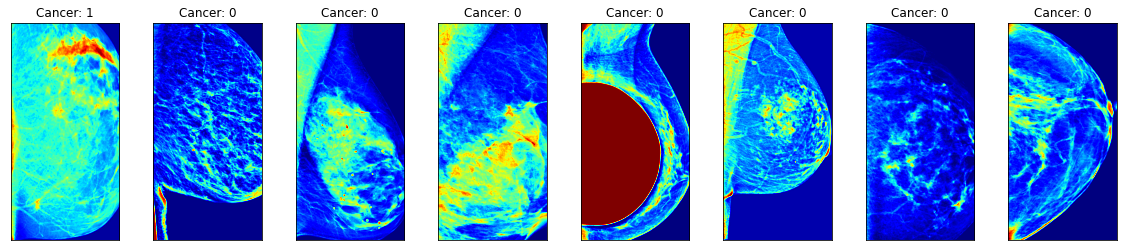

In [31]:
def display_batch(dataset):
    images, labels = next(iter(dataset))
    clear_output() # Clear "Cleanup called..."
    plt.figure(figsize=(20, BATCH_SIZE / 2))
    for i in range(BATCH_SIZE):
        plt.subplot(int(BATCH_SIZE / 8), 8, i + 1)
        plt.title(f"Cancer: {int(labels[i])}", fontsize=12)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i], cmap='jet')
    plt.show()
    
display_batch(train_dataset)

# Competition metric
The evaluation metric used in this competition is the **probabilistic F1 score (pF1)**, which is a variation of the traditional F1 score that takes into account the probabilities of predictions rather than binary classifications.

Additionally, the pF1 score also includes a version that allows for a greater emphasis on precision over recall by adjusting the beta parameter. The general formula for this version is as follows:

$$ pF_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{(\beta^2 \cdot precision) + recall} $$
Where,
$$ precision = \frac{pTP}{pTP + pFP} \hspace{1cm} recall = \frac{pTP}{TP + FN} $$

**Note:**

When the beta parameter is set to a value less than 1, the model is rewarded for having a higher recall even if the precision is lower. On the other hand, when the beta parameter is greater than 1, the model is rewarded for having a higher precision even if the recall is lower. In this competition, the beta parameter is set to 1, which results in the probabilistic F1 score (pF1) which gives equal importance to precision and recall. The model will be rewarded for achieving a balance between the two.

In [33]:
class pFBeta(tf.keras.metrics.Metric):
    def __init__(self, beta=1, name='pF1', **kwargs):
        super().__init__(name=name, **kwargs)
        self.beta = beta
        self.epsilon = 1e-10
        self.pos = self.add_weight(name='pos', initializer='zeros')
        self.ctp = self.add_weight(name='ctp', initializer='zeros')
        self.cfp = self.add_weight(name='cfp', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 0, 1)
        pos = tf.cast(tf.reduce_sum(y_true), tf.float32)
        ctp = tf.cast(tf.reduce_sum(y_pred[y_true == 1]), tf.float32)
        cfp = tf.cast(tf.reduce_sum(y_pred[y_true == 0]), tf.float32)
        self.pos.assign_add(pos)
        self.ctp.assign_add(ctp)
        self.cfp.assign_add(cfp)
        
    def result(self):
        beta2 = self.beta * self.beta
        prec = self.ctp / (self.ctp + self.cfp + self.epsilon)
        reca = self.ctp / (self.pos + self.epsilon)
        return (1 + beta2) * prec * reca / (beta2 * prec + reca)
        
    def reset_state(self):
        self.pos.assign(0.)
        self.ctp.assign(0.)
        self.cfp.assign(0.)

# Model
In the normalizer function, the images are:
- **Duplicated** to get 3 channels required for the pretrained model input
- **Converted** from `uint8` to `float32`
- **Scaled** between 0 and 1 and then normalized with respect to the ImageNet dataset.

In [15]:
def normalizer(img):
    img = tf.repeat(img, repeats=3, axis=3)
    img = tf.cast(img, tf.float32)
    img = tf.keras.applications.imagenet_utils.preprocess_input(img, mode='torch')
    return img

In [16]:
def create_model():
    # Mixed Policy Settings
    print(f'Compute dtype: {tf.keras.mixed_precision.global_policy().compute_dtype}')
    print(f'Variable dtype: {tf.keras.mixed_precision.global_policy().variable_dtype}')
    
    with STRATEGY.scope():
        seeding()
        
        # Architecture
        inputs = tf.keras.Input(INPUT_SHAPE, name='inputs', dtype=tf.uint8)
        x = normalizer(inputs)
        x = convnext.ConvNeXtV2Tiny(
            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
            pretrained='imagenet21k-ft1k',
            num_classes=0)(x)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dropout(0.30)(x)
        outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        model = tf.keras.Model(inputs, outputs)
        
        # Optimizer
        optimizer = tfa.optimizers.AdamW(
            learning_rate=LR_MAX,
            weight_decay=LR_MAX * WD_RATIO,
            epsilon=1e-6)
        
        # Loss
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        
        # Metrics
        metrics = [pFBeta(beta=1, name='pF1'),
                   tfa.metrics.F1Score(num_classes=1, threshold=0.50, name='F1'),
                   tf.metrics.Precision(name='Prec'),
                   tf.metrics.Recall(name='Reca'),
                   tf.metrics.AUC(name='AUC'),
                   tf.metrics.BinaryAccuracy(name='BinAcc')]
        
        # Compile
        model.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=metrics)
        return model

    
tf.keras.backend.clear_session()
tf.config.optimizer.set_jit(True)

model = create_model()

Compute dtype: float32
Variable dtype: float32
115146752/115145456 [==============================] - 2s 0us/step
>>>> Load pretrained from: /root/.keras/models/convnext_v2_tiny_384_imagenet21k-ft1k.h5


Now the model is created, let's see how it looks.

**Note**: The biggest block is the `conv_v2_tiny` and it can be displayed by setting `expand_nested=True`.

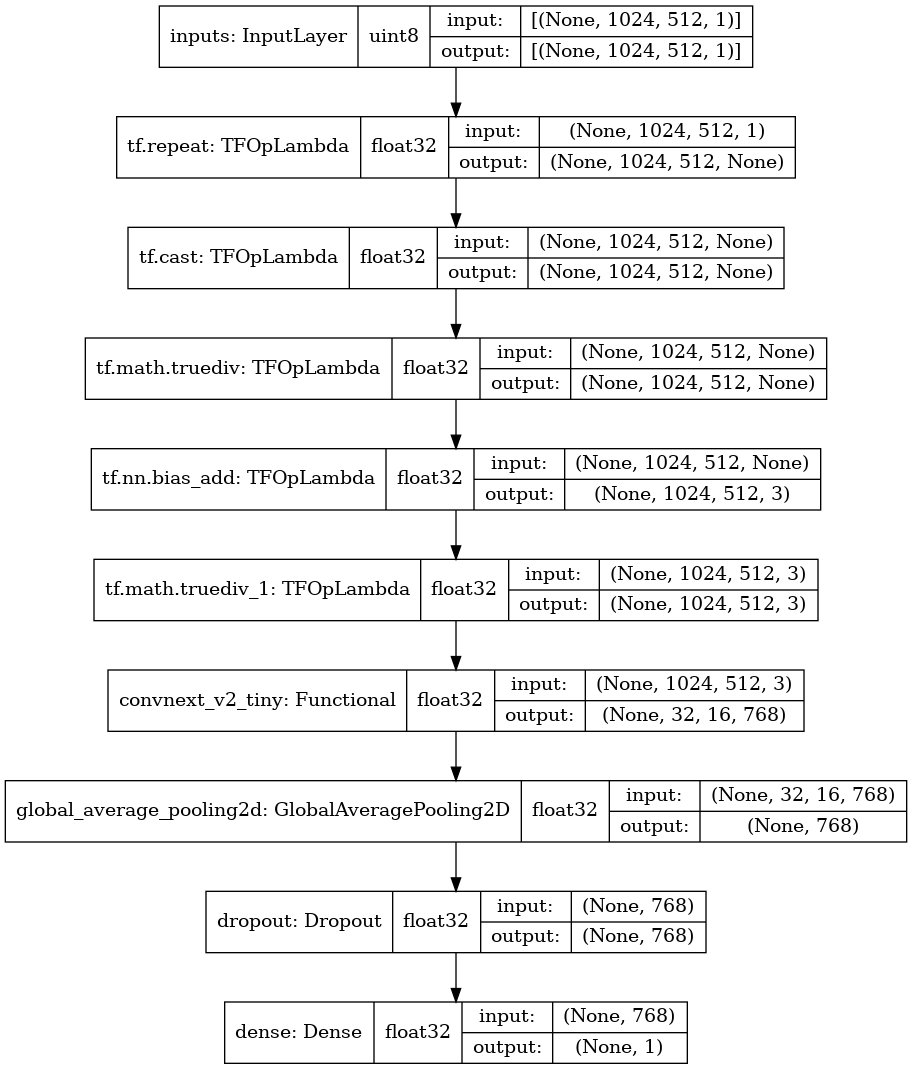

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True,
                          show_layer_names=True, expand_nested=False)

# Learning Rate Scheduler
It is common to control the learning rate during training and decrease it along epochs. Let's use a cosine function and display it.

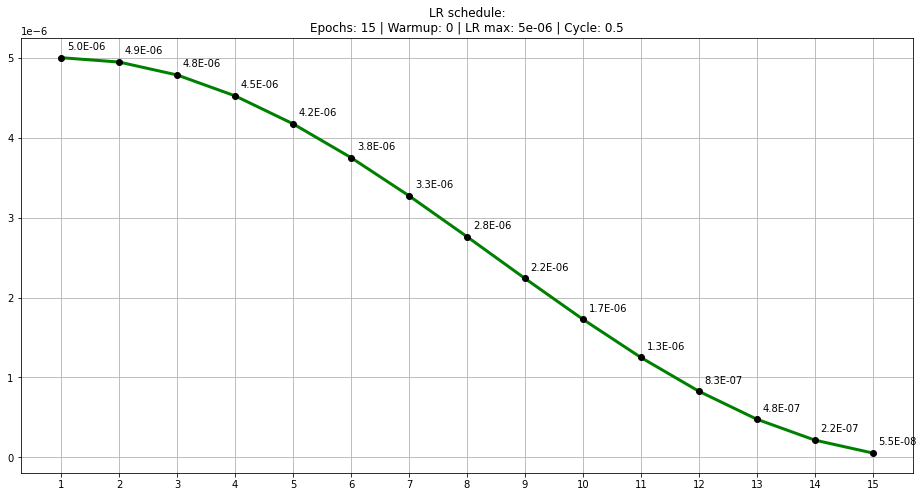

In [35]:
def lr_fn(step, epochs=EPOCHS, warmup=WARMUP,
          lr_max=LR_MAX, cycle=CYCLE):
    if step < warmup:
        lr = lr_max * 0.10 ** (warmup - step)
    else:
        progress = float(step - warmup) / float(max(1, epochs - warmup))
        lr = max(0.0, 0.5 * (1.0 + np.cos(2.0 * np.pi * float(cycle) * progress))) * lr_max
    return lr


def plot_lr_schedule(epochs=EPOCHS, warmup=WARMUP,
                     lr_max=LR_MAX, cycle=CYCLE):
    steps = np.array(range(epochs))
    lrs = np.vectorize(lr_fn)(steps, epochs, warmup, lr_max, cycle)
    plt.figure(figsize=(16, 8))
    plt.plot(steps + 1, lrs, '-', color='green', lw=3)
    plt.plot(steps + 1, lrs, 'o', color='black')
    offset_y = (max(lrs) - min(lrs)) * 0.02
    for x, y in zip(steps, lrs):
        plt.annotate('%.1E' % y, xy=(x+1.1, y+offset_y))
    plt.xticks(range(1, epochs + 1))
    plt.grid(True)
    plt.title(f"LR schedule:\nEpochs: {epochs} | Warmup: {warmup} | LR max: {lr_max} | Cycle: {cycle}")
    plt.show()


plot_lr_schedule()

This is the callback used in the fit function.

In [19]:
lr_schedule = [lr_fn(step) for step in range(EPOCHS)]
lr_callback = tf.keras.callbacks.LearningRateScheduler(
    lambda step: lr_schedule[step], verbose=0)

# Weight Decay Callback

In [20]:
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f"Learning rate: {model.optimizer.learning_rate.numpy():.2e}")
        print(f"Weight decay: {model.optimizer.weight_decay.numpy():.2e}")

# Training

In [21]:
history = model.fit(
    x=train_dataset,
    epochs=EPOCHS,
    verbose=VERBOSE,
    callbacks=[lr_callback],
    validation_data=valid_dataset,
    class_weight={0: 1.0, 1: 5.0},
    steps_per_epoch=TRAIN_STEPS_PER_EPOCH
)

Epoch 1/10
685/685 [==============================] - 319s 367ms/step - loss: 0.8023 - pF1: 0.1068 - F1: 0.0661 - Prec: 0.0660 - Reca: 0.0680 - AUC: 0.5378 - BinAcc: 0.8740 - val_loss: 0.2589 - val_pF1: 0.0561 - val_F1: 0.1227 - val_Prec: 0.1075 - val_Reca: 0.1429 - val_AUC: 0.7583 - val_BinAcc: 0.9608


2023-01-24 14:08:06.480097: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 32706, Output num: 3
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1674569286.476572666","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 32706, Output num: 3","grpc_status":3}


Epoch 2/10
685/685 [==============================] - 215s 313ms/step - loss: 0.6035 - pF1: 0.1782 - F1: 0.2835 - Prec: 0.2615 - Reca: 0.3100 - AUC: 0.7432 - BinAcc: 0.9024 - val_loss: 0.1416 - val_pF1: 0.1386 - val_F1: 0.2726 - val_Prec: 0.2122 - val_Reca: 0.3810 - val_AUC: 0.8327 - val_BinAcc: 0.9610
Epoch 3/10
685/685 [==============================] - 215s 314ms/step - loss: 0.4444 - pF1: 0.3035 - F1: 0.4648 - Prec: 0.4046 - Reca: 0.5474 - AUC: 0.8783 - BinAcc: 0.9215 - val_loss: 0.3596 - val_pF1: 0.1019 - val_F1: 0.1475 - val_Prec: 0.0834 - val_Reca: 0.6381 - val_AUC: 0.8429 - val_BinAcc: 0.8584
Epoch 4/10
685/685 [==============================] - 215s 313ms/step - loss: 0.3089 - pF1: 0.4363 - F1: 0.6123 - Prec: 0.5215 - Reca: 0.7426 - AUC: 0.9446 - BinAcc: 0.9415 - val_loss: 0.1629 - val_pF1: 0.1784 - val_F1: 0.2491 - val_Prec: 0.1675 - val_Reca: 0.4857 - val_AUC: 0.8460 - val_BinAcc: 0.9438
Epoch 5/10
685/685 [==============================] - 215s 314ms/step - loss: 0.1783 - p

In [22]:
# Save model weights for inference
model.save_weights('model.h5')

# Plots

In [23]:
# https://www.kaggle.com/code/markwijkhuizen/rsna-convnextv2-training-tensorflow-tpu?scriptVersionId=116484001
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    plt.figure(figsize=(20, 10))
    
    values = history.history[metric]
    N_EPOCHS = len(values)
    val = 'val' in ''.join(history.history.keys())
    # Epoch Ticks
    if N_EPOCHS <= 20:
        x = np.arange(1, N_EPOCHS + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]

    x_ticks = np.arange(1, N_EPOCHS+1)

    # Validation
    if val:
        val_values = history.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.plot(x_ticks, val_values, label=f'val')

    # summarize history for accuracy
    plt.plot(x_ticks, values, label=f'train')
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
    if val:
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)
        
    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)        
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)
    
    plt.legend(prop={'size': 10})
    plt.grid()
    plt.show()

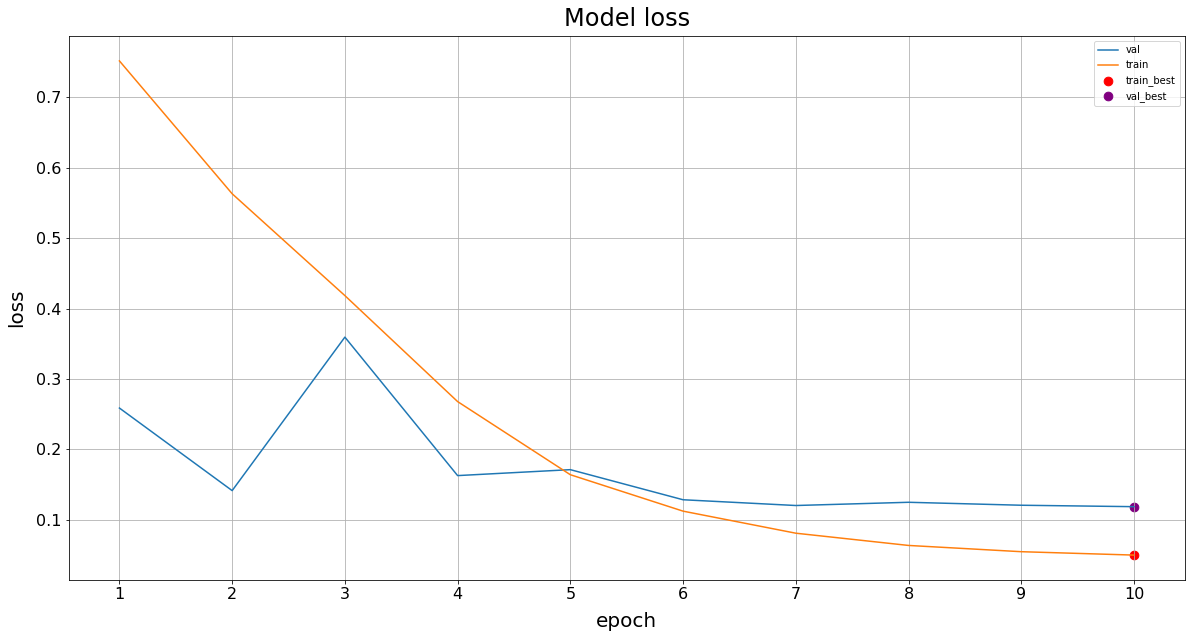

In [24]:
plot_history_metric('loss', f_best=np.argmin)

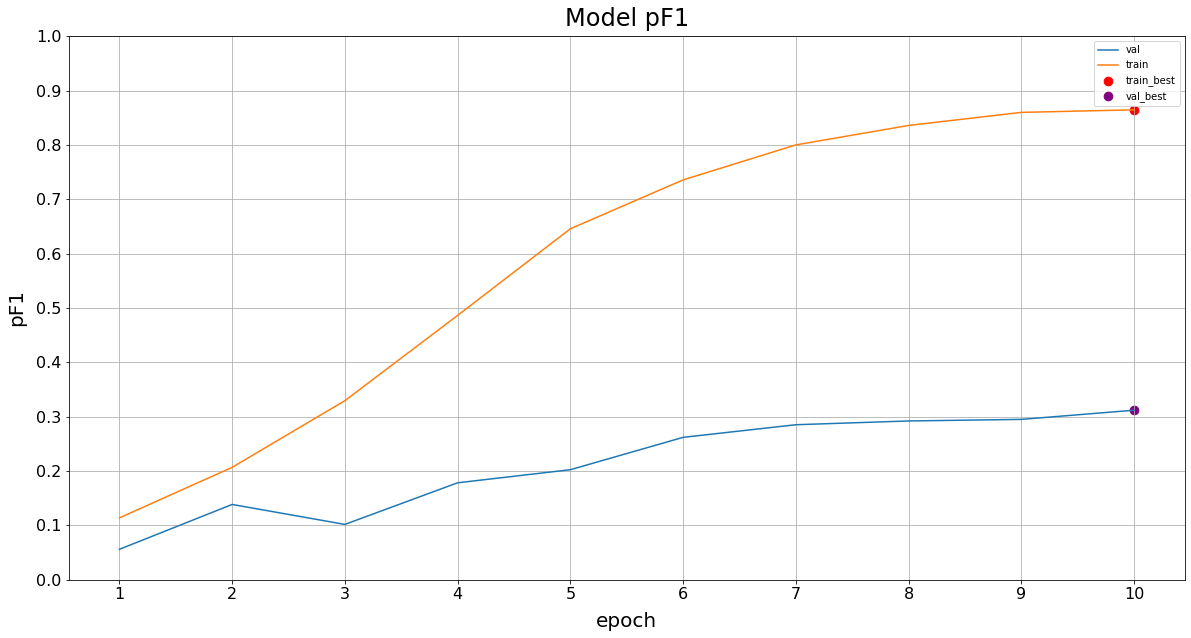

In [25]:
plot_history_metric('pF1', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

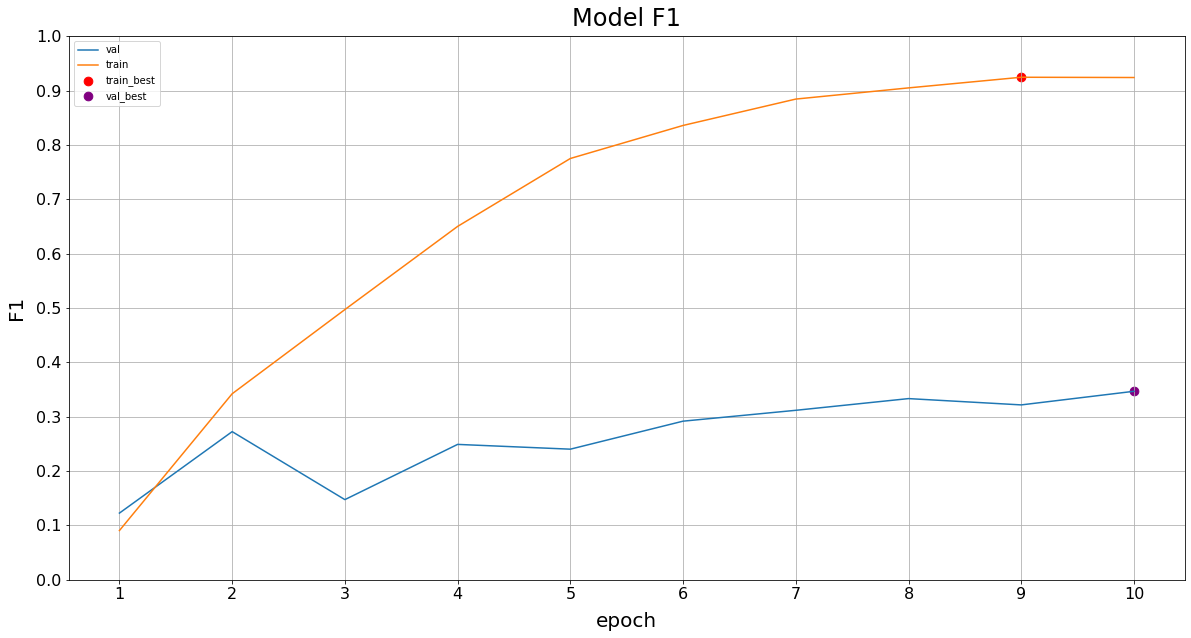

In [28]:
plot_history_metric('F1', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

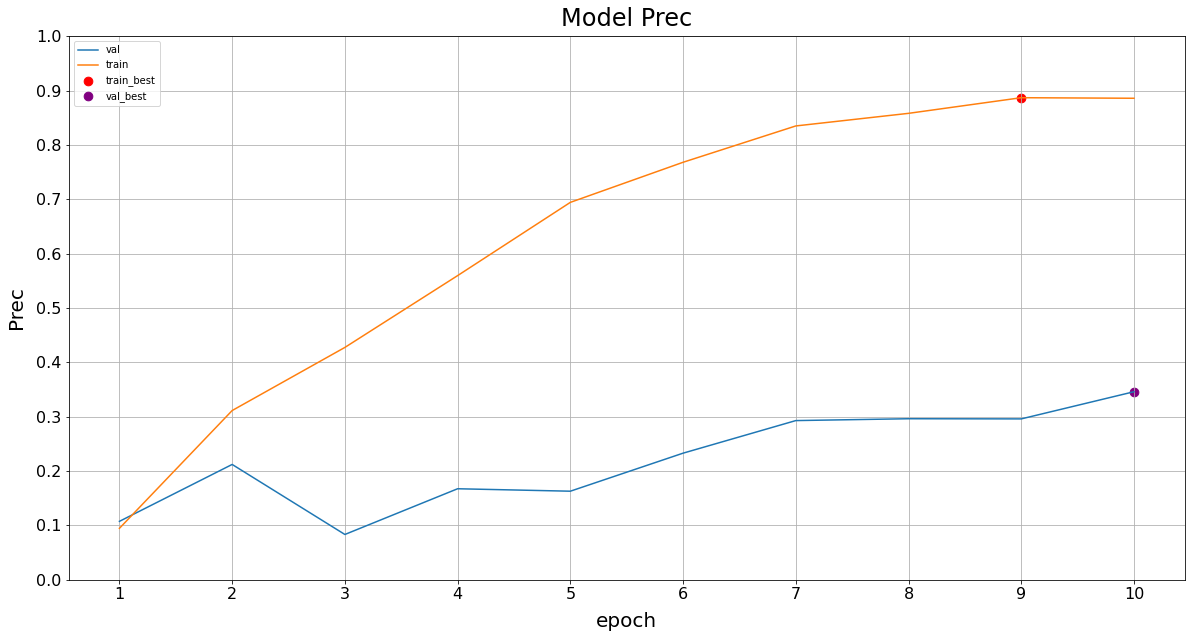

In [30]:
plot_history_metric('Prec', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

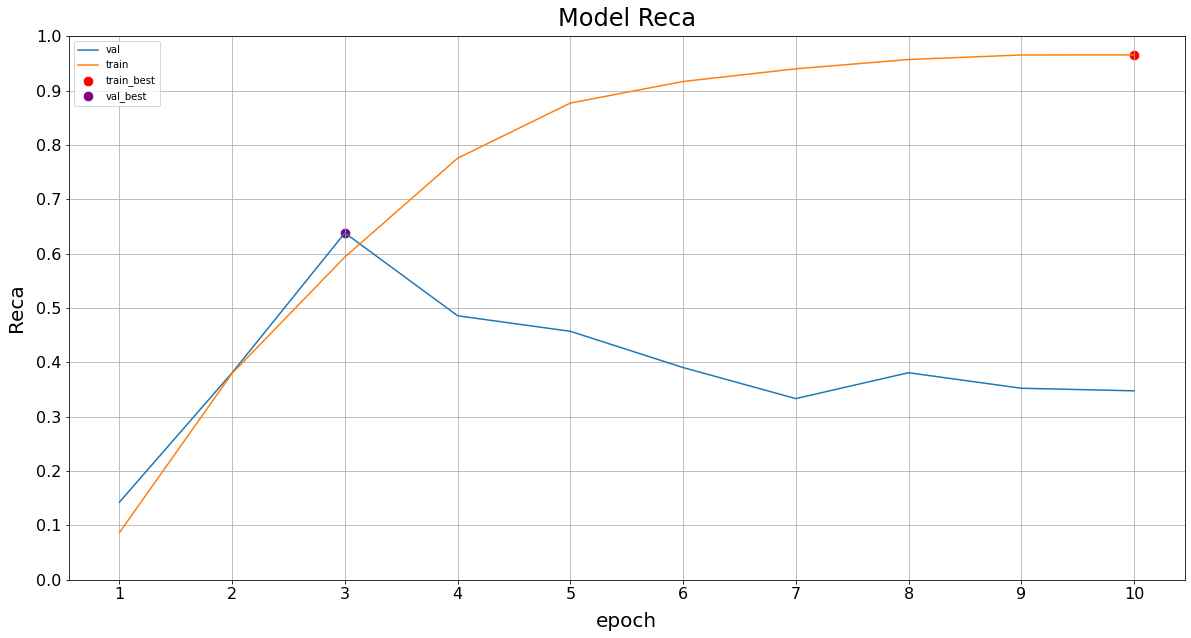

In [32]:
plot_history_metric('Reca', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

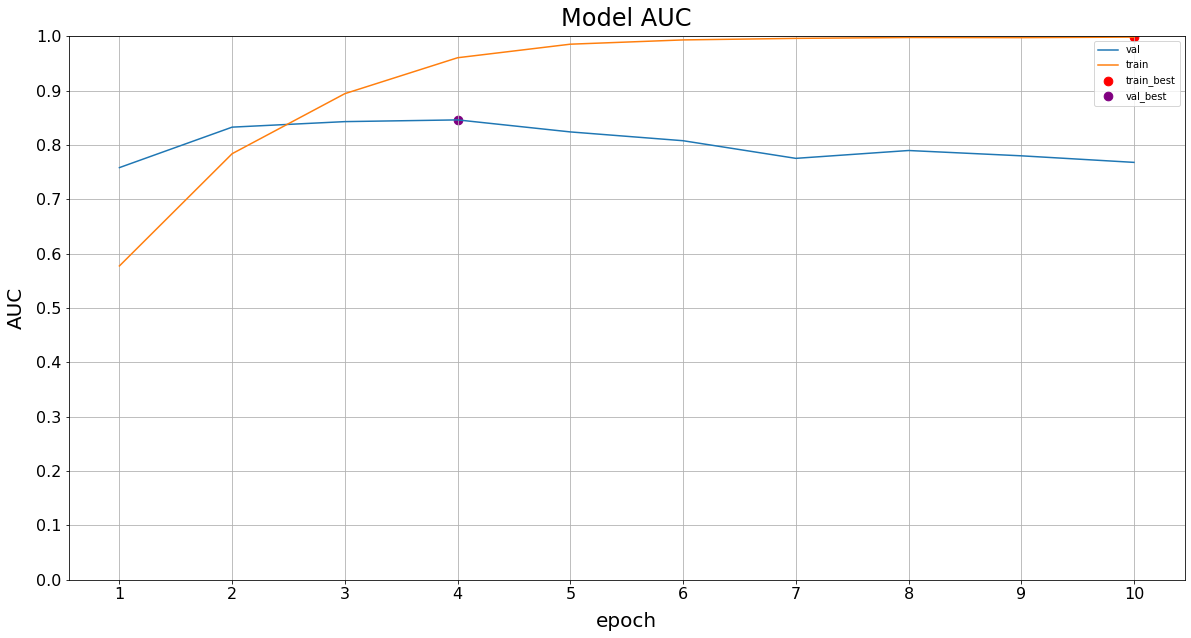

In [33]:
plot_history_metric('AUC', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

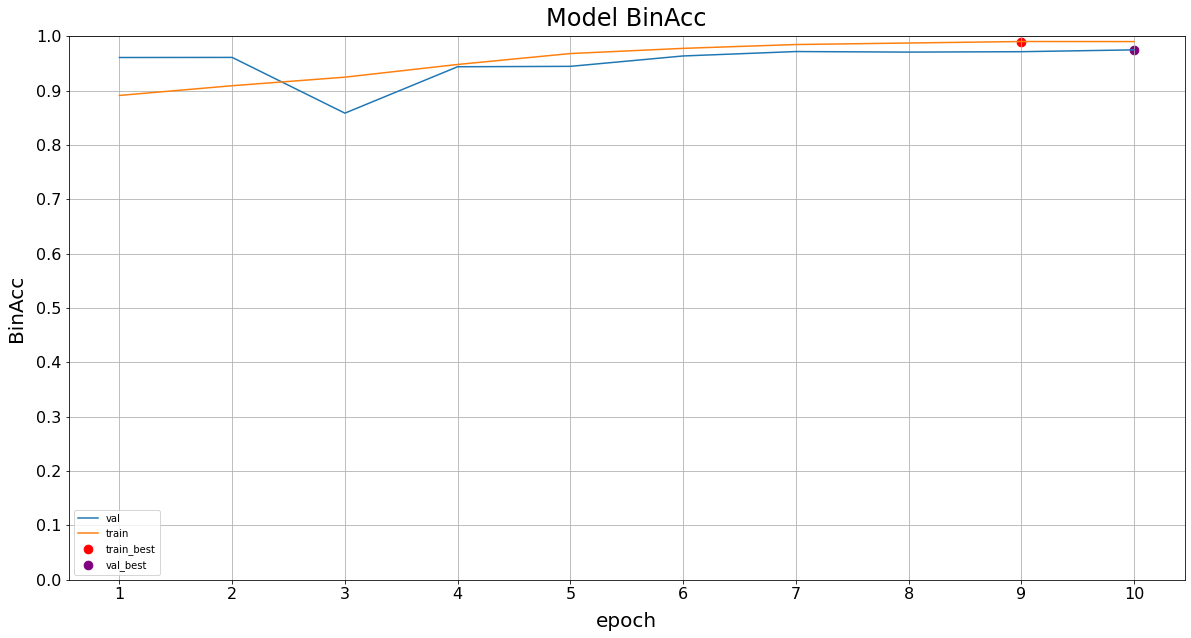

In [34]:
plot_history_metric('BinAcc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))